# Reconstructing DICOM Data

In [1]:
import sys 
import os
import numpy as np
import torch
import pytomography
from pytomography.io.SPECT import dicom
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEMOSL
from pytomography.projections import SystemMatrix
import matplotlib.pyplot as plt
import torch
import pydicom
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytomography.device = device

First we specify the required filepaths for the SPECT scan (`file_NM`) and the corresponding filepaths for the atteunation map. Note that

In [2]:
# initialize the `path`` variable below to specify the location of the required data
path = '' 
path_CT = os.path.join(path, 'CT_files')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]
file_AM = os.path.join(path, 'attenuation_map.dcm')
file_NM = os.path.join(path, 'projection_data.dcm')

The object meta, image meta, and photopeak can be obtained using the `dicom_projections_to_data` function. Note that most raw SPECT DICOM files contain data from multiple energy windows. If the `index_peak` argument isn't included, then projections the third argument it returns would contain all energy windows (along the batch dimension). In this case, we specify `index_peak=3`, so it only returns the projections corresponding to that energy window. This infomation can be obtained by opening the dicom file using pydicom and looking at the `EnergyWindowInformationSequence` attribute

In [3]:
object_meta, image_meta, photopeak = dicom.get_projections(file_NM, index_peak=3)

Scatter projections can be estimated using the triple energy window function `dicom_get_scatterTEW`. One needs to specify the index of the peak, and lower/upper energy windows

In [4]:
scatter = dicom.get_scatter_from_TEW(file_NM, index_peak=3, index_lower=2, index_upper=4)

The attenuation map can be obtained in two ways

1. (Preferable): If you have access to an attenuation map from the manufactorer in a single DICOM file, you should use this. This is obtained using the `get_attenuation_map_from_file`
2. (Last Resort): If you don't have access to this attenuation map, then you're not out of luck. PyTomography has functionality to arrange, align, resize, and rescale a sequence of CT scans into an attenuation map. It  uses an approximate bilinear relationship between Hounsfield Units and linear attenuation coefficients. Because accurate conversion between Hounsfield Units depends non-trivially on the CT system parameters as well as the SPECT system parameters, [this paper](https://jnm.snmjournals.org/content/57/1/151.long) recommends using the manufacturers attenuation map. If you don't have access to this, however, you can use the `get_attenuation_map_from_CT_slices` function, and give as input the files corresponding to the CT scan, the raw projection file name, and the index in the raw projection file corresponding to the photopeak.

In [5]:
attenuation_map_from_file = dicom.get_attenuation_map_from_file(file_AM)
attenuation_map_from_CT_slices = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, index_peak=3)

We can compare the vendor obtained attenuation map and the approximated one below:

In [6]:
sample_slice_from_file = attenuation_map_from_file[0][:,70].T
sample_slice_from_CT_slices = attenuation_map_from_CT_slices[0][:,70].T
ratio = (sample_slice_from_file+1e-3)/(sample_slice_from_CT_slices+1e-3)

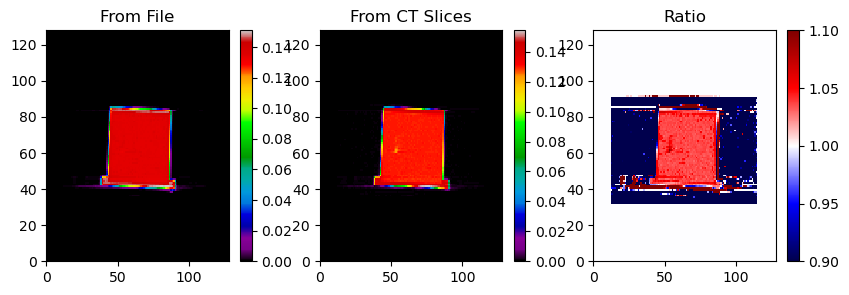

In [7]:
plt.subplots(1,3,figsize=(10,3))
plt.subplot(131)
plt.title('From File')
plt.pcolormesh(sample_slice_from_file, cmap='nipy_spectral')
plt.colorbar()
plt.subplot(132)
plt.title('From CT Slices')
plt.pcolormesh(sample_slice_from_CT_slices, cmap='nipy_spectral')
plt.colorbar()
plt.subplot(133)
plt.title('Ratio')
plt.pcolormesh(ratio, cmap='seismic', vmin=0.9, vmax=1.1)
plt.colorbar()

While the two maps are very similar, they differ by approximately $\pm 5\%$ in highly attenuating regions. This minor difference can have singificant implications on the reconstruction (as we shall see shortly).

We can obtain the required parameters for PSF modeling provided we know the name of the scanner (`scanner_model`), the type of collimators used (`collimator_name`) and the energy (`energy_kev`) for finding the linear attenuation coefficient of lead:

In [8]:
camera_model = 'SymbiaTSeries'
collimator_name = 'HE'
energy_kev = 200
psf_meta = dicom.get_psfmeta_from_scanner_params(camera_model, collimator_name, energy_kev)
print(f"collimator slope: {psf_meta.collimator_slope}")
print(f"collimator intercept: {psf_meta.collimator_intercept}")

collimator slope: 0.02932444355906164
collimator intercept: 0.16986436005760383


# Reconstruct the object

We're now ready to reconstruct the DICOM object. We'll try using attenuation correction with both the vendors attenuation map and the one created by PyTomography

So we'll create a function that performs reconstruction given a particular attenuation map:

In [9]:
def reconstruct_phantom(attenuation_map):
    # Create transforms
    att_transform = SPECTAttenuationTransform(attenuation_map)
    psf_transform = SPECTPSFTransform(psf_meta)
    # Create system matrix
    system_matrix = SystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        im2im_transforms = [],
        object_meta = object_meta,
        image_meta = image_meta)
    # Initialize reconstruction algorithm
    reconstruction_algorithm = OSEMOSL(
        image = photopeak,
        system_matrix = system_matrix,
        scatter=scatter)
    # Reconstruct object
    reconstructed_object = reconstruction_algorithm(n_iters=4, n_subsets=10)
    return reconstructed_object

In [10]:
reconstructed_object_atten_from_file = reconstruct_phantom(attenuation_map_from_file)
reconstructed_object_atten_from_CT_slices = reconstruct_phantom(attenuation_map_from_CT_slices)

We'll compare these reconstructions to one done on the vendors software, which also performed OSEM with 4 iterations, 10 subsets, with attenuation modeling, PSF modeling, and triple energy window scatter correction.

In [11]:
ds_recon = pydicom.read_file(os.path.join(path, 'scanner_recon.dcm'))
reconstructed_object_vendor = ds_recon.pixel_array / 90
reconstructed_object_vendor = np.transpose(reconstructed_object_vendor, (2,1,0))

# Plotting

We can looks at axial slices from all three reconstructions.

In [12]:
slice_atten_from_file = reconstructed_object_atten_from_file.cpu()[0][:,:,70].T
slice_atten_from_CT_slices = reconstructed_object_atten_from_CT_slices.cpu()[0][:,:,70].T
slice_vendor = reconstructed_object_vendor[:,:,70].T

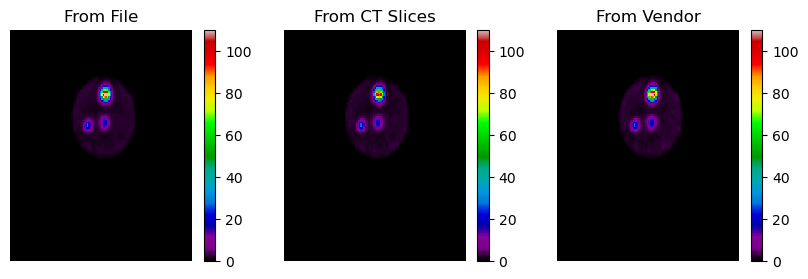

In [13]:
plt.subplots(1,3,figsize=(10,3))
plt.subplot(131)
plt.title('From File')
plt.pcolormesh(slice_atten_from_file , cmap='nipy_spectral', vmax=110)
plt.axis('off')
plt.colorbar()
plt.subplot(132)
plt.title('From CT Slices')
plt.pcolormesh(slice_atten_from_CT_slices, cmap='nipy_spectral', vmax=110)
plt.axis('off')
plt.colorbar()
plt.subplot(133)
plt.title('From Vendor')
plt.pcolormesh(slice_vendor, cmap='nipy_spectral', vmax=110)
plt.axis('off')
plt.colorbar()
plt.show()

Careful observation of the top bright lobe shows that the reconstruction obtained by using the vendors attenuation map gives a reconstruction more consistent with the vendor than that using seperate CT slices.